# Assignment 3: Policy Gradients (DDPG and REINFORCE)

Name:

ID:

## Background
This exercise requires you to solve various continous control problems in OpenAI-Gym.  

DDPG is policy gradient actor critic method for continous control which is off policy. It tackles the curse of dimensionality / loss of performance faced when discretizing a continous action domain. DDPG uses similiar "tricks" as DQN to improve the stability of training, including a replay buffer and target networks.

Furthermore, you will implement REINFORCE for discrete and continous environments, and as a bonus compare the sample efficiency and performance with DQN and DDPG.


### DDPG paper: https://arxiv.org/pdf/1509.02971.pdf

### Environments:

#### InvertedPendulum-v2 environment:
<img src="inverted_pendulum.png" width="300">

#### Pendulum-v0 environment:
<img src="pendulum.png" width="300">

#### Halfcheetah-v2 environment:
<img src="half_cheetah.png" width="300">



### Setup environment for Actor Critic
- inline plotting
- gym
- directory for logging videos

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import time

#environment
import gym

#pytorch
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

### Implement an action normalization class:
To train across various environments, it is useful to normalize action inputs and outputs between [-1, 1]. This class should take in actions and implement forward and reverse functions to map actions between [-1, 1] and [action_space.low, action_space.high].

Using the following gym wrapper, implement this class.
- https://github.com/openai/gym/blob/78c416ef7bc829ce55b404b6604641ba0cf47d10/gym/core.py
- i.e. we are overriding the outputs scale of actions. 

In [2]:
class NormalizeAction(gym.ActionWrapper):
    def _action(self, action):
        #tanh outputs (-1,1) from tanh, need to be [action_space.low, action_space.high]
        act_k = (self.action_space.high - self.action_space.low)/ 2.
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k * action + act_b

    def _reverse_action(self, action):
        #reverse of that above
        act_k_inv = 2./(self.action_space.high - self.action_space.low)
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k_inv * (action - act_b)

### Set up gym environment
The code below does the following for you:
- Wrap environment, log videos, setup CUDA variables (if GPU is available)
- Record action and observation space dimensions
- Fix random seed for determinisitic training

In [12]:
VISUALIZE = True
SEED = 0
MAX_PATH_LENGTH = 2000
NUM_EPISODES = 12000
GAMMA=0.99
BATCH_SIZE = 128
logging_interval = 50
animate_interval = logging_interval * 5

# Environments to be tested on
#env_name = 'InvertedPendulum-v1'
#env_name = 'Pendulum-v0'
env_name = 'HalfCheetah-v1' 
logdir='./DDPG/'+env_name

# wrap gym to save videos
env = NormalizeAction(gym.make(env_name))

if VISUALIZE:
    if not os.path.exists(logdir):
        os.mkdir(logdir)
    env = gym.wrappers.Monitor(env, logdir, force=True, video_callable=lambda episode_id: episode_id%logging_interval==0)
env._max_episode_steps = MAX_PATH_LENGTH

# check observation and action space
discrete = isinstance(env.action_space, gym.spaces.Discrete)
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.n if discrete else env.action_space.shape[0]

if discrete:
    print("This is a discrete action space, probably not the right algorithm to use")

# set random seeds
torch.manual_seed(SEED)
np.random.seed(SEED)

# make variable types for automatic setting to GPU or CPU, depending on GPU availability
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

def to_numpy(var):
    return var.cpu().data.numpy() if use_cuda else var.data.numpy()

def to_tensor(x, volatile=False, requires_grad=True, dtype=Tensor):
    x = torch.from_numpy(x).float()
    x = Variable(x, requires_grad=requires_grad).type(dtype=dtype)
    return x

[2018-05-23 19:47:29,594] Making new env: HalfCheetah-v1
[2018-05-23 19:47:29,603] Clearing 2 monitor files from previous run (because force=True was provided)


### Demonstrate your understanding of the simulation:
For the environments mentioned above ('Pendulum-v0', 'HalfCheetah-v2', 'InvertedPendulum-v2'),
- describe the reward system
- describe the each state variable (observation space)
- describe the action space
- when is the environment considered "solved"?

# DDPG

### Write a weight syncing function
In contrast to DQN, DDPG uses soft weight sychronization. At each time step following training, the actor and critic target network weights are updated to track the rollout networks. 
- target_network.weights <= target_network.weights \* (1 - tau) + source_network.weights \* (tau)

In [13]:
def weightSync(target_model, source_model, tau = 0.001):
    for parameter_target, parameter_source in zip(target_model.parameters(), source_model.parameters()):
        parameter_target.data.copy_((1 - tau) * parameter_target.data + tau * parameter_source.data)

### Write a Replay class that includes all the functionality of a replay buffer
DDPG is an off policy actor-critic method and an identical replay buffer to that used for the previous assignment is applicable here as well (do not include the generate_minibatch method in your Replay class this time). Like before, your constructor for Replay should create an initial buffer of size 1000 when you instantiate it.

The replay buffer should kept to some maximum size (60000), allow adding of samples and returning of samples at random from the buffer. Each sample (or experience) is formed as (state, action, reward, next_state, done). 

In [14]:
import random

class Replay(object):
    def __init__(self, max_size):
        self.buffer = []
        self.capacity = max_size
        self.position = 0
        self.initialize(init_length=1000)
        
    def add_experience(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (np.asarray(state), action, reward,\
                                      np.asarray(next_state), done)
        self.position = (self.position+1)%self.capacity
    
    def initialize(self, init_length, env=env):
        state = env.reset()
        while True:
            action = np.random.uniform(-1.0, 1.0, size=env.action_space.shape)
            next_state, reward, done, _ = env.step(action)
            self.add_experience(state, action, reward, next_state, done)
            if done:
                state = env.reset()
                if len(self.buffer)>=init_length:
                    break
            else:
                state = next_state
    
    def sample(self, batch_size):
        states = []
        actions = []
        rewards = []
        next_states = []
        terminates = []
        samples = random.sample(self.buffer, batch_size)
        for state, action, reward, next_state, done in samples:
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)
            terminates.append(done)
        
        states = np.array(states, dtype=np.float).reshape(batch_size,-1)
        actions = np.array(actions, dtype=np.float).reshape(batch_size,-1)
        rewards = np.array(rewards, dtype=np.float).reshape(batch_size,-1)
        next_states = np.array(next_states, dtype=np.float).reshape(batch_size,-1)
        terminates = np.array(terminates, dtype=np.float).reshape(batch_size,-1)
        return states, actions, rewards, next_states, terminates

### Write an Ornstein Uhlenbeck process class for exploration noise
The proccess is described here:
- https://en.wikipedia.org/wiki/Ornstein–Uhlenbeck_process
- http://math.stackexchange.com/questions/1287634/implementing-ornstein-uhlenbeck-in-matlab

You should implement:
- a step / sample method
- reset method

Use theta = 0.15, mu = 0, sigma = 0.3, dt = 0.01

In [15]:
class OrnsteinUhlenbeckProcess(object):
    def __init__(self, dimension, num_steps, theta=0.25, mu=0.0, sigma=0.05, dt=0.01):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x = np.zeros((dimension,))
        self.iter = 0
        self.num_steps = num_steps
        self.dimension = dimension
        self.min_epsilon = 0.01 # minimum exploration probability
        self.epsilon = 1.0
        self.decay_rate = 5.0/num_steps # exponential decay rate for exploration prob
    
    def sample(self):
        self.x = self.x + self.theta*(self.mu-self.x)*self.dt + \
                                       self.sigma*np.sqrt(self.dt)*np.random.normal(size=self.dimension)
        return self.epsilon*self.x
    
    def reset(self):
        self.x = 0*self.x
        self.iter += 1
        self.epsilon = self.min_epsilon + (1.0 - self.min_epsilon)*np.exp(-self.decay_rate*self.iter)

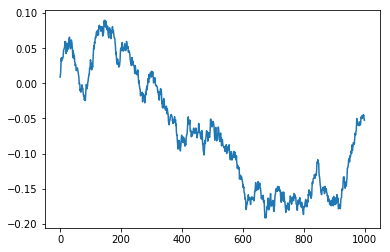

In [16]:
noise = OrnsteinUhlenbeckProcess(dimension=1,num_steps=1000)
y = np.zeros((1000))
for i in range(1000):
    y[i] = noise.sample()
plt.plot(range(1000),y)

### Write a Deep Neural Network class that creates a dense network of a desired architecture for actor and critic networks


#### Actor
- input and hidden layer activation function: ReLU

- output activation function: Tanh

- hidden_state sizes: 400

- state and action sizes: variable

- number of hidden layers: 2

- batch normalization applied to all hidden layers

- weight initialization: normal distribution with small variance. 

#### Critic
- input and hidden layer activation function: ReLU

- output activation function: None

- hidden_state sizes: 300, 300 + action size

- state and action sizes: variable

- number of hidden layers: 2

- batch normalization applied to all hidden layers prior to the action input

- weight initialization: normal distribution with small variance.

Good baselines can be found in the paper.

In [17]:
# ----------------------------------------------------
# actor model, MLP
# ----------------------------------------------------
# 2 hidden layers, 400 units per layer, tanh output to bound outputs between -1 and 1
def fanin_init(size, fanin=None):
    fanin = fanin or size[0]
    v = 1. / np.sqrt(fanin)
    return torch.Tensor(size).normal_(0.0, v)

class actor(nn.Module):
    def __init__(self, input_size, output_size):
        super(actor, self).__init__()
        self.fc1 = nn.Linear(input_size, 400)
        self.bn1 = nn.BatchNorm1d(400)
        self.fc2 = nn.Linear(400, 400)
        self.bn2 = nn.BatchNorm1d(400)
        self.fc3 = nn.Linear(400, output_size)
        self.init_weights()
    
    def init_weights(self, init_w=10e-3):
        self.fc1.weight.data = fanin_init(self.fc1.weight.data.size())
        self.fc2.weight.data = fanin_init(self.fc2.weight.data.size())
        self.fc3.weight.data.normal_(0, 3e-3)

    def forward(self, state):
        out = self.fc1(state)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.fc2(out)
        out = self.bn2(out)
        out = F.relu(out)
        action = F.tanh(self.fc3(out))
        return action


# ----------------------------------------------------
# critic model, MLP
# ----------------------------------------------------
# 2 hidden layers, 300 units per layer, ouputs rewards therefore unbounded
# Action not to be included until 2nd layer of critic (from paper). Make sure 
# to formulate your critic.forward() accordingly

class critic(nn.Module):
    def __init__(self, state_size, action_size, output_size):
        super(critic, self).__init__()
        self.fc1 = nn.Linear(state_size, 300)
        #self.bn1 = nn.BatchNorm1d(300)
        self.fc2 = nn.Linear(300 + action_size, 300)
        self.fc3 = nn.Linear(300, output_size)
        self.init_weights()
    
    def init_weights(self, init_w=10e-3):
        self.fc1.weight.data = fanin_init(self.fc1.weight.data.size())
        self.fc2.weight.data = fanin_init(self.fc2.weight.data.size())
        self.fc3.weight.data.normal_(0, 3e-4)
        
    def forward(self, state, action):
        out = self.fc1(state)
        #out = self.bn1(out)
        out = F.relu(out)
        out = F.relu(self.fc2(torch.cat([out,action],1)))
        qvalue = self.fc3(out)
        return qvalue

### Define DDPG class to encapsulate definition, rollouts, and training

- gamma = 0.99

- actor_lr = 1e-4

- critic_lr = 1e-3

- critic l2 regularization = 1e-2

- noise decay

- noise class

- batch_size = 128

- optimizer: Adam

- loss (critic): mse

Furthermore, you can experiment with action versus parameter space noise. The standard implimentation works with action space noise, howeve parameter space noise has shown to produce excellent results.


In [18]:
OBS_DIM = env.observation_space.shape[0]
ACT_DIM = env.action_space.shape[0]

In [19]:
class DDPG:
    def __init__(self, obs_dim, act_dim, critic_lr = 1e-3, actor_lr = 1e-4, gamma = 0.99, alpha_decay=0.93, batch_size = 64):
        
        self.gamma = gamma
        self.batch_size = batch_size
        self.obs_dim = obs_dim
        self.act_dim = act_dim
        
        # actor
        self.actor = actor(input_size = obs_dim, output_size = act_dim).type(FloatTensor)
        self.actor.cuda()
        self.actor_target = actor(input_size = obs_dim, output_size = act_dim).type(FloatTensor)
        self.actor_target.cuda()
        self.actor_target.load_state_dict(self.actor.state_dict())

        # critic
        self.critic = critic(state_size = obs_dim, action_size = act_dim, output_size = 1).type(FloatTensor)
        self.critic.cuda()
        self.critic_target = critic(state_size = obs_dim, action_size = act_dim, output_size = 1).type(FloatTensor)
        self.critic_target.cuda()
        self.critic_target.load_state_dict(self.critic.state_dict())

        # optimizers
        self.optimizer_actor = torch.optim.Adam(self.actor.parameters(), lr = actor_lr)
        self.optimizer_critic = torch.optim.Adam(self.critic.parameters(), lr = critic_lr, weight_decay=1e-2)
        
        # learning rate scheduler
        self.scheduler_actor = optim.lr_scheduler.StepLR(self.optimizer_actor, step_size=5000, gamma=alpha_decay)
        self.scheduler_critic = optim.lr_scheduler.StepLR(self.optimizer_critic, step_size=5000, gamma=alpha_decay)
        
        
        # critic loss
        self.critic_loss = nn.MSELoss()
        
        # noise
        self.noise = OrnsteinUhlenbeckProcess(dimension = act_dim, num_steps = NUM_EPISODES)

        # replay buffer 
        self.replayBuffer = Replay(60000)
        
        
    def train(self):
     
        # sample from Replay
        states, actions, rewards, next_states, terminates = self.replayBuffer.sample(self.batch_size)

        # update critic (create target for Q function)
        target_qvalues = self.critic_target(to_tensor(next_states, volatile=True),\
                                           self.actor_target(to_tensor(next_states, volatile=True)))
        #target_qvalues.volatile = False
        y = to_numpy(to_tensor(rewards) +\
            self.gamma*to_tensor(1-terminates)*target_qvalues)

        q_values = self.critic(to_tensor(states),
                               to_tensor(actions))
        qvalue_loss = self.critic_loss(q_values, to_tensor(y, requires_grad=False))
        
               
        # critic optimizer and backprop step (feed in target and predicted values to self.critic_loss)
        self.critic.zero_grad()
        qvalue_loss.backward()
        self.optimizer_critic.step()
        self.scheduler_critic.step()
        

        # update actor (formulate the loss wrt which actor is updated)
        policy_loss = -self.critic(to_tensor(states),\
                                 self.actor(to_tensor(states)))
        policy_loss = policy_loss.mean()
        

        # actor optimizer and backprop step (loss_actor.backward())
        self.actor.zero_grad()
        policy_loss.backward()
        self.optimizer_actor.step()
        self.scheduler_actor.step()
        
        # sychronize target network with fast moving one
        weightSync(self.critic_target, self.critic)
        weightSync(self.actor_target, self.actor)
        

### Create an instance of your DDPG object
- Print network architectures, confirm they are correct

In [20]:
ddpg = DDPG(obs_dim=OBS_DIM, act_dim=ACT_DIM, gamma=GAMMA, batch_size=BATCH_SIZE)
print(ddpg.actor)
print(ddpg.critic)

[2018-05-23 19:47:33,911] Starting new video recorder writing to /datasets/home/09/409/ee276cae/Reinforcement-Learning/hw3 - Policy Gradients/DDPG/HalfCheetah-v1/openaigym.video.1.146.video000000.mp4


actor(
  (fc1): Linear(in_features=17, out_features=400, bias=True)
  (bn1): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=400, out_features=400, bias=True)
  (bn2): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=400, out_features=6, bias=True)
)
critic(
  (fc1): Linear(in_features=17, out_features=300, bias=True)
  (fc2): Linear(in_features=306, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=1, bias=True)
)


### Train DDPG on different environments
Early stopping conditions:
- avg_val > 500 for "InvertedPendulum" 
- avg_val > -150 for "Pendulum" 
- avg_val > 1500 for "HalfCheetah" 



In [21]:
avg_val = 0

#for plotting
running_rewards_ddpg = []
step_list_ddpg = []
step_counter = 0

# set term_condition for early stopping according to environment being used
term_condition = 1500 # Pendulum

reached = False

for itr in range(NUM_EPISODES):
    state = env.reset() # get initial state
    animate_this_episode = (itr % animate_interval == 0) and VISUALIZE
    ddpg.noise.reset()
    step = 0
    total_reward = 0

    while True:
        if animate_this_episode:
                env.render()
                time.sleep(0.05)

        # use actor to get action, add ddpg.noise.step() to action
        # remember to put NN in eval mode while testing (to deal with BatchNorm layers) and put it back 
        # to train mode after you're done getting the action
        ddpg.actor.eval()
        state = state.reshape(1,-1)
        noise = ddpg.noise.sample()
        action = to_numpy(ddpg.actor(to_tensor(state))).reshape(-1,) + noise
        if not reached:
            ddpg.actor.train()
                
        # step action, get next state, reward, done (keep track of total_reward)
        # populate ddpg.replayBuffer
        next_state, reward, done, _ = env.step(action)
        ddpg.replayBuffer.add_experience(state.ravel(), action, reward, next_state, done)
        total_reward += reward

        ddpg.train()
        step_counter += 1
        
        if done:
            break

        state = next_state
        step+=1
    
    print(step_counter, total_reward)

    if avg_val > term_condition and itr>10:
        reached = True
    
    if reached and itr%logging_interval==1:
        break

    running_rewards_ddpg.append(total_reward) # return of this episode
    step_list_ddpg.append(step_counter)

    avg_val = avg_val * 0.95 + 0.05*running_rewards_ddpg[-1]
    print("Average value: {} for episode: {}".format(avg_val,itr))
    itr+=1


1000 -427.5220172093445
Average value: -21.376100860467226 for episode: 0
2000 -510.96916432070884
Average value: -45.8557540334793 for episode: 1
3000 -505.3008051153264
Average value: -68.82800658757165 for episode: 2
4000 -530.0561979412972
Average value: -91.88941615525793 for episode: 3
5000 -521.1955441289641
Average value: -113.35472255394323 for episode: 4
6000 -518.1808625188688
Average value: -133.59602955218952 for episode: 5
7000 -585.2007165965466
Average value: -156.17626390440736 for episode: 6
8000 -471.29240847497135
Average value: -171.93207113293556 for episode: 7
9000 -475.7661690474804
Average value: -187.1237760286628 for episode: 8
10000 -521.8213445543764
Average value: -203.85865445494846 for episode: 9
11000 -458.83831557409104
Average value: -216.6076375109056 for episode: 10
12000 -476.7653594395515
Average value: -229.61552360733788 for episode: 11
13000 -518.4659420356934
Average value: -244.05804452875563 for episode: 12
14000 -341.6295061007451
Average v

[2018-05-23 19:53:36,800] Starting new video recorder writing to /datasets/home/09/409/ee276cae/Reinforcement-Learning/hw3 - Policy Gradients/DDPG/HalfCheetah-v1/openaigym.video.1.146.video000050.mp4


48000 587.1525510967867
Average value: 4.854990867758506 for episode: 47
49000 556.5716544091665
Average value: 32.44082404482891 for episode: 48
50000 640.0406875259424
Average value: 62.820817218884585 for episode: 49
51000 -31.8592666852931
Average value: 58.0868130236757 for episode: 50
52000 656.2045272318577
Average value: 87.9926987340848 for episode: 51
53000 654.7143500234199
Average value: 116.32878129855155 for episode: 52
54000 481.3587245212271
Average value: 134.58027845968533 for episode: 53
55000 728.5588284012575
Average value: 164.27920595676392 for episode: 54
56000 775.3778396338064
Average value: 194.83413764061604 for episode: 55
57000 650.7172180118343
Average value: 217.62829165917697 for episode: 56
58000 710.3277465030286
Average value: 242.26326440136955 for episode: 57
59000 804.5480967166685
Average value: 270.37750601713446 for episode: 58
60000 783.7140889706207
Average value: 296.0443351648088 for episode: 59
61000 818.0433933551367
Average value: 322.14

[2018-05-23 19:58:51,905] Starting new video recorder writing to /datasets/home/09/409/ee276cae/Reinforcement-Learning/hw3 - Policy Gradients/DDPG/HalfCheetah-v1/openaigym.video.1.146.video000100.mp4


98000 904.2045671047891
Average value: 782.1093482004435 for episode: 97
99000 1023.7333172549371
Average value: 794.1905466531681 for episode: 98
100000 1082.3995749426508
Average value: 808.6009980676422 for episode: 99
101000 1208.579984937209
Average value: 828.5999474111205 for episode: 100
102000 1150.2766652006167
Average value: 844.6837833005953 for episode: 101
103000 1056.0994336547062
Average value: 855.2545658183009 for episode: 102
104000 1256.4473919115228
Average value: 875.3142071229619 for episode: 103
105000 1110.3861066106615
Average value: 887.0678020973468 for episode: 104
106000 -191.86554253301662
Average value: 833.1211348658286 for episode: 105
107000 865.0075277365416
Average value: 834.7154545093641 for episode: 106
108000 670.4496498649645
Average value: 826.5021642771442 for episode: 107
109000 1099.906174760788
Average value: 840.1723648013264 for episode: 108
110000 683.274017312503
Average value: 832.3274474268852 for episode: 109
111000 1176.97993767253

[2018-05-23 20:04:02,878] Starting new video recorder writing to /datasets/home/09/409/ee276cae/Reinforcement-Learning/hw3 - Policy Gradients/DDPG/HalfCheetah-v1/openaigym.video.1.146.video000150.mp4


148000 1612.7756932969812
Average value: 1258.0082001622604 for episode: 147
149000 1435.1831163574434
Average value: 1266.8669459720195 for episode: 148
150000 100.89585360919459
Average value: 1208.5683913538783 for episode: 149
151000 1533.6262699337399
Average value: 1224.8212852828713 for episode: 150
152000 1613.0221425424609
Average value: 1244.2313281458505 for episode: 151
153000 1244.6457015382111
Average value: 1244.2520468154685 for episode: 152
154000 165.82515891603234
Average value: 1190.3307024204967 for episode: 153
155000 284.61018057984387
Average value: 1145.044676328464 for episode: 154
156000 1693.58301122758
Average value: 1172.4715930734196 for episode: 155
157000 1664.6050935236901
Average value: 1197.0782680959333 for episode: 156
158000 1709.0159061122242
Average value: 1222.6751499967477 for episode: 157
159000 1763.3469369836712
Average value: 1249.7087393460938 for episode: 158
160000 1779.874324140517
Average value: 1276.217018585815 for episode: 159
1610

[2018-05-23 20:09:06,894] Starting new video recorder writing to /datasets/home/09/409/ee276cae/Reinforcement-Learning/hw3 - Policy Gradients/DDPG/HalfCheetah-v1/openaigym.video.1.146.video000200.mp4


198000 1765.3413394065951
Average value: 1664.452760389193 for episode: 197
199000 1801.087786999162
Average value: 1671.2845117196912 for episode: 198
200000 1798.5839677893384
Average value: 1677.6494845231737 for episode: 199
201000 1712.0424921165861
Average value: 1679.369134902844 for episode: 200
202000 1874.6978648615388


## Plot rewards over multiple training runs 
This is provided to generate and plot results for you.

[2018-05-23 20:50:16,390] Finished writing results. You can upload them to the scoreboard via gym.upload('/datasets/home/09/409/ee276cae/Reinforcement-Learning/hw3 - Policy Gradients/DDPG/HalfCheetah-v1')


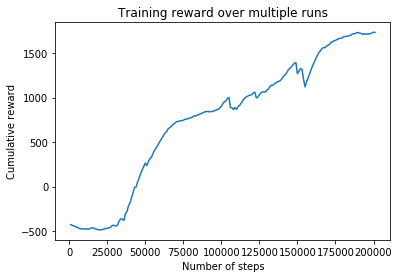

In [30]:
def numpy_ewma_vectorized_v2(data, window):

    alpha = 2 /(window + 1.0)
    alpha_rev = 1-alpha
    n = data.shape[0]

    pows = alpha_rev**(np.arange(n+1))

    scale_arr = 1/pows[:-1]
    offset = data[0]*pows[1:]
    pw0 = alpha*alpha_rev**(n-1)

    mult = data*pw0*scale_arr
    cumsums = mult.cumsum()
    out = offset + cumsums*scale_arr[::-1]
    return out

plt.figure()
out = numpy_ewma_vectorized_v2(np.array(running_rewards_ddpg),20)
step_list_ddpg = np.array(step_list_ddpg)

plt.plot(step_list_ddpg, out)
plt.title('Training reward over multiple runs')
plt.xlabel('Number of steps')
plt.ylabel('Cumulative reward')
plt.show()

# REINFORCE

In this section you will implement REINFORCE, with modifications for batch training. It will be for use on both discrete and continous action spaces.

## Policy Parametrization

Define a MLP which outputs a distribution over the action preferences given input state. For the discrete case, the MLP outputs the likelihood of each action (softmax) while for the continuous case, the output is the mean and standard deviation parametrizing the normal distribution from which the action is sampled.



In [53]:
# ----------------------------------------------------
# Policy parametrizing model, MLP
# ----------------------------------------------------
# 1 or 2 hidden layers with a small number of units per layer (similar to DQN)
# use ReLU for hidden layer activations
# softmax as activation for output if discrete actions, linear for continuous control
# for the continuous case, output_dim=2*act_dim (each act_dim gets a mean and std_dev)
def fanin_init(size, fanin=None):
    fanin = fanin or size[0]
    v = 1. / np.sqrt(fanin)
    return torch.Tensor(size).normal_(0.0, v)

class mlp(nn.Module):
    def __init__(self, discrete, input_size, output_size):
        super(mlp, self).__init__()
        self.discrete = discrete
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 128)
        if discrete:
            self.fc3 = nn.Linear(128, output_size)
        else:
            self.fc3 = nn.Linear(128, 2*output_size)
            
        self.init_weights()
        self.optimizer = torch.optim.Adam(self.parameters(), lr = learning_rate)
    
    def init_weights(self, init_w=10e-3):
        self.fc1.weight.data = fanin_init(self.fc1.weight.data.size())
        self.fc2.weight.data = fanin_init(self.fc2.weight.data.size())
        self.fc3.weight.data.normal_(0, 3e-3)            
        
    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        if discrete:
            out = F.softmax(self.fc3(out), dim=0)
        else:
            out = self.fc3(out)
        return out

Define a function that samples an action from the policy distribtion parameters obtained as output of the MLP. The function should return the action and the log-probability (log_odds) of taking that action. 

In [54]:
def sample_action(logit, discrete, env):
    # logit is the output of the softmax/linear layer
    # discrete is a flag for the environment type
    # Hint: use Categorical and Normal from torch.distributions to sample action and get the log-probability
    # Note that log_probability in this case translates to ln(\pi(a|s)) 
    if discrete:
        dist = torch.distributions.Categorical(logit)
    else:
        l = logit.shape[0]//2
        Sigma = F.sigmoid(logit[l:]) * to_tensor(env.action_space.high - env.action_space.low)
        #dist = torch.distributions.Normal(logit[:l], Sigma)
        dist = torch.distributions.Normal(logit[:l], F.softplus(logit[l:]))
    action = dist.sample()
    log_prob = dist.log_prob(action)
    return action.cpu().data.numpy(), log_prob


Create a function update_policy that defines the loss function and updates the MLP according to the REINFORCE update rule (ref. slide 24 of Lec 7 or page 330 of Sutton and Barto (2018)). The update algorithm to be used below is slightly different: instead of updating the network at every time-step, we take the gradient of the loss averaged over a batch of timesteps (this is to make SGD more stable). We also use a baseline to reduce variance. 

The discount factor is set as 1 here. 


In [55]:
def update_policy(paths, net):
    # paths: a list of paths (complete episodes, used to calculate return at each time step)
    # net: MLP object

    policy_loss = to_tensor(np.zeros((len(paths))))
    
    for i,path in enumerate(paths):
        reward = to_tensor(path['reward'])
        
        revIdx = np.array([idx for idx in range(reward.shape[0]-1,-1,-1)])
        
        revIdx = to_tensor(revIdx, dtype=LongTensor)
        inverted_reward = reward.index_select(0, revIdx)
        inverted_reward = torch.cumsum(inverted_reward, dim=0)
        rews_cum = inverted_reward.index_select(0, revIdx)
        rews_cum = (rews_cum - rews_cum.mean()) / (rews_cum.std() + 1e-5) # create baseline
        
        log_prob = path['log_probs']
        policy_loss[i] = torch.matmul(-rews_cum,log_prob).sum()
        # log_probs should record log_odds obtained at each timestep of path
         
        # calculated as "reward to go"

    # make log_probs, rew_cums each a vector
        
    # calculate policy loss and average over paths
    policy_loss = policy_loss.mean()
    
    # take optimizer step
    net.optimizer.zero_grad()
    policy_loss.backward()
    net.optimizer.step()

Set up environment and instantiate objects. Your algorithm is to be tested on one discrete and two continuous environments. 



In [56]:
min_timesteps_per_batch = 2000  # sets the batch size for updating network
logging_interval = 100
animate_interval = logging_interval * 1

# Select Environment

#discrete environment:
env_name='CartPole-v0'

#continous environments:
#env_name='InvertedPendulum-v1'
#env_name = 'HalfCheetah-v1'

#env_name='InvertedPendulum-v1'

# Make the gym environment
env = gym.make(env_name)
visualize = True
animate=False

learning_rate = 1e-3

max_path_length=1000
env._max_episode_steps = max_path_length


# Set random seeds
seed=0
torch.manual_seed(seed)
np.random.seed(seed)

# Saving parameters
logdir='./REINFORCE/'+env_name


if visualize:
    if not os.path.exists(logdir):
        os.mkdir(logdir)
    env = gym.wrappers.Monitor(env, logdir, force=True, video_callable=lambda episode_id: episode_id%animate_interval==0)
env._max_episode_steps = min_timesteps_per_batch


# Is this env continuous, or discrete?
discrete = isinstance(env.action_space, gym.spaces.Discrete)

# Get observation and action space dimensions
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.n if discrete else env.action_space.shape[0]

# Maximum length for episodes
max_path_length = max_path_length or env.spec.max_episode_steps

# Make network object (remember to pass in appropriate flags for the type of action space in use)
net = mlp(discrete, obs_dim, act_dim)
net.cuda()

[2018-05-23 21:08:40,989] Making new env: CartPole-v0
[2018-05-23 21:08:41,101] Finished writing results. You can upload them to the scoreboard via gym.upload('/datasets/home/09/409/ee276cae/Reinforcement-Learning/hw3 - Policy Gradients/DQN/CartPole-v0')
[2018-05-23 21:08:41,109] Clearing 86 monitor files from previous run (because force=True was provided)


mlp(
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
)

In [57]:
f1_in = net.fc1.weight.cpu().data.numpy()
f2_in = net.fc2.weight.cpu().data.numpy()
f3_in = net.fc3.weight.cpu().data.numpy()

## Run REINFORCE

Run REINFORCE for CartPole, InvertedPendulum, and HalfCheetah. 

In [58]:
VISUALIZE = True
n_iter = 1000 
avg_reward = 0
avg_rewards = []
step_list_reinforce = []
total_steps = 0
episodes = 0
reached = animate_interval

for itr in range(n_iter): # loop for number of optimization steps
    paths = []
    steps = 0
    
    while True: # loop to get enough timesteps in this batch --> if episode ends this loop will restart till steps reaches limit
        state = env.reset()
        obs, acs, rews, log_probs = [], [], [], []
        animate_this_episode = (itr % animate_interval == 0) and VISUALIZE
       
        while True: # loop for episode inside batch
            if animate_this_episode:
                env.render()
                time.sleep(0.05)
            
            # get parametrized policy distribution from net using current state ob
            logit = net(to_tensor(state))
            
            # sample action and get log-probability (log_odds) from distribution
            action, log_prob = sample_action(logit, discrete, env)
            
            # step environment, record reward, next state
            next_state, reward, done, _ = env.step(action)
            
            # append to obs, acs, rewards, log_odds
            obs.append(state)
            acs.append(action)
            rews.append(reward)
            log_probs.append(log_prob)
            
            # if done, restart episode till min_timesteps_per_batch is reached
            
            steps += 1
            
            if done:
                episodes = episodes + 1
                break
                
            state = next_state
                
        path = {"observation" : obs, 
                "reward" : np.array(rews), 
                "action" : (acs),
                "log_probs" : torch.stack(log_probs)}
        
        paths.append(path)
        
        if steps > min_timesteps_per_batch:
            break 
        
    #print(paths)
    update_policy(paths, net)  # use all complete episodes (a batch of timesteps) recorded in this itr to update net
    if itr == 0:
        avg_reward = path['reward'].sum()
    else:
        avg_reward = avg_reward * 0.95 + 0.05 * path['reward'].sum()
    
    if avg_reward > 300:
        state = env.reset()
        if reached>0:
            break
        reached += 1
    
    total_steps += steps
    avg_rewards.append(avg_reward)
    step_list_reinforce.append(total_steps)
    #print(itr,total_steps,path['reward'],len(paths))
    if itr % 1 == 0:
        print('Average reward: {}'.format(avg_reward))
   
      
env.close()

[2018-05-23 21:08:45,064] Starting new video recorder writing to /datasets/home/09/409/ee276cae/Reinforcement-Learning/hw3 - Policy Gradients/REINFORCE/CartPole-v0/openaigym.video.6.146.video000000.mp4
[2018-05-23 21:10:32,793] Starting new video recorder writing to /datasets/home/09/409/ee276cae/Reinforcement-Learning/hw3 - Policy Gradients/REINFORCE/CartPole-v0/openaigym.video.6.146.video000100.mp4


Average reward: 13.0
Average reward: 13.4


[2018-05-23 21:10:34,915] Starting new video recorder writing to /datasets/home/09/409/ee276cae/Reinforcement-Learning/hw3 - Policy Gradients/REINFORCE/CartPole-v0/openaigym.video.6.146.video000200.mp4


Average reward: 15.43


[2018-05-23 21:10:37,409] Starting new video recorder writing to /datasets/home/09/409/ee276cae/Reinforcement-Learning/hw3 - Policy Gradients/REINFORCE/CartPole-v0/openaigym.video.6.146.video000300.mp4


Average reward: 15.558499999999999


[2018-05-23 21:10:39,597] Starting new video recorder writing to /datasets/home/09/409/ee276cae/Reinforcement-Learning/hw3 - Policy Gradients/REINFORCE/CartPole-v0/openaigym.video.6.146.video000400.mp4


Average reward: 18.430574999999997


[2018-05-23 21:10:41,702] Starting new video recorder writing to /datasets/home/09/409/ee276cae/Reinforcement-Learning/hw3 - Policy Gradients/REINFORCE/CartPole-v0/openaigym.video.6.146.video000500.mp4


Average reward: 19.409046249999996


[2018-05-23 21:10:44,260] Starting new video recorder writing to /datasets/home/09/409/ee276cae/Reinforcement-Learning/hw3 - Policy Gradients/REINFORCE/CartPole-v0/openaigym.video.6.146.video000600.mp4


Average reward: 20.388593937499994


[2018-05-23 21:10:47,247] Starting new video recorder writing to /datasets/home/09/409/ee276cae/Reinforcement-Learning/hw3 - Policy Gradients/REINFORCE/CartPole-v0/openaigym.video.6.146.video000700.mp4


Average reward: 20.069164240624993
Average reward: 19.865706028593742


[2018-05-23 21:10:49,586] Starting new video recorder writing to /datasets/home/09/409/ee276cae/Reinforcement-Learning/hw3 - Policy Gradients/REINFORCE/CartPole-v0/openaigym.video.6.146.video000800.mp4


Average reward: 19.872420727164055


[2018-05-23 21:10:51,969] Starting new video recorder writing to /datasets/home/09/409/ee276cae/Reinforcement-Learning/hw3 - Policy Gradients/REINFORCE/CartPole-v0/openaigym.video.6.146.video000900.mp4


Average reward: 23.32879969080585


[2018-05-23 21:10:54,166] Starting new video recorder writing to /datasets/home/09/409/ee276cae/Reinforcement-Learning/hw3 - Policy Gradients/REINFORCE/CartPole-v0/openaigym.video.6.146.video001000.mp4


Average reward: 24.76235970626556


[2018-05-23 21:10:56,382] Starting new video recorder writing to /datasets/home/09/409/ee276cae/Reinforcement-Learning/hw3 - Policy Gradients/REINFORCE/CartPole-v0/openaigym.video.6.146.video001100.mp4


Average reward: 24.72424172095228


[2018-05-23 21:10:59,399] Starting new video recorder writing to /datasets/home/09/409/ee276cae/Reinforcement-Learning/hw3 - Policy Gradients/REINFORCE/CartPole-v0/openaigym.video.6.146.video001200.mp4


Average reward: 24.88802963490466
Average reward: 24.443628153159427


[2018-05-23 21:11:01,569] Starting new video recorder writing to /datasets/home/09/409/ee276cae/Reinforcement-Learning/hw3 - Policy Gradients/REINFORCE/CartPole-v0/openaigym.video.6.146.video001300.mp4


Average reward: 24.421446745501452


[2018-05-23 21:11:03,654] Starting new video recorder writing to /datasets/home/09/409/ee276cae/Reinforcement-Learning/hw3 - Policy Gradients/REINFORCE/CartPole-v0/openaigym.video.6.146.video001400.mp4


Average reward: 25.250374408226378


[2018-05-23 21:11:05,902] Starting new video recorder writing to /datasets/home/09/409/ee276cae/Reinforcement-Learning/hw3 - Policy Gradients/REINFORCE/CartPole-v0/openaigym.video.6.146.video001500.mp4


Average reward: 25.487855687815056


[2018-05-23 21:11:09,121] Starting new video recorder writing to /datasets/home/09/409/ee276cae/Reinforcement-Learning/hw3 - Policy Gradients/REINFORCE/CartPole-v0/openaigym.video.6.146.video001600.mp4


Average reward: 24.9134629034243
Average reward: 26.717789758253083


[2018-05-23 21:11:11,617] Starting new video recorder writing to /datasets/home/09/409/ee276cae/Reinforcement-Learning/hw3 - Policy Gradients/REINFORCE/CartPole-v0/openaigym.video.6.146.video001700.mp4


Average reward: 27.281900270340426


[2018-05-23 21:11:15,090] Starting new video recorder writing to /datasets/home/09/409/ee276cae/Reinforcement-Learning/hw3 - Policy Gradients/REINFORCE/CartPole-v0/openaigym.video.6.146.video001800.mp4


Average reward: 27.5678052568234
Average reward: 26.98941499398223


[2018-05-23 21:11:17,668] Starting new video recorder writing to /datasets/home/09/409/ee276cae/Reinforcement-Learning/hw3 - Policy Gradients/REINFORCE/CartPole-v0/openaigym.video.6.146.video001900.mp4


Average reward: 26.18994424428312


[2018-05-23 21:11:20,931] Starting new video recorder writing to /datasets/home/09/409/ee276cae/Reinforcement-Learning/hw3 - Policy Gradients/REINFORCE/CartPole-v0/openaigym.video.6.146.video002000.mp4


Average reward: 26.43044703206896
Average reward: 26.058924680465513


[2018-05-23 21:11:23,727] Starting new video recorder writing to /datasets/home/09/409/ee276cae/Reinforcement-Learning/hw3 - Policy Gradients/REINFORCE/CartPole-v0/openaigym.video.6.146.video002100.mp4


Average reward: 28.505978446442235
Average reward: 28.83067952412012


[2018-05-23 21:11:27,299] Starting new video recorder writing to /datasets/home/09/409/ee276cae/Reinforcement-Learning/hw3 - Policy Gradients/REINFORCE/CartPole-v0/openaigym.video.6.146.video002200.mp4


Average reward: 29.089145547914114
Average reward: 30.334688270518406


[2018-05-23 21:11:30,832] Starting new video recorder writing to /datasets/home/09/409/ee276cae/Reinforcement-Learning/hw3 - Policy Gradients/REINFORCE/CartPole-v0/openaigym.video.6.146.video002300.mp4


Average reward: 30.317953856992485
Average reward: 30.452056164142856


[2018-05-23 21:11:35,119] Starting new video recorder writing to /datasets/home/09/409/ee276cae/Reinforcement-Learning/hw3 - Policy Gradients/REINFORCE/CartPole-v0/openaigym.video.6.146.video002400.mp4


Average reward: 32.029453355935715
Average reward: 32.377980688138926


[2018-05-23 21:11:39,041] Starting new video recorder writing to /datasets/home/09/409/ee276cae/Reinforcement-Learning/hw3 - Policy Gradients/REINFORCE/CartPole-v0/openaigym.video.6.146.video002500.mp4


Average reward: 34.70908165373198
Average reward: 34.67362757104538


[2018-05-23 21:11:42,869] Starting new video recorder writing to /datasets/home/09/409/ee276cae/Reinforcement-Learning/hw3 - Policy Gradients/REINFORCE/CartPole-v0/openaigym.video.6.146.video002600.mp4


Average reward: 35.03994619249311
Average reward: 36.63794888286846


[2018-05-23 21:11:47,351] Starting new video recorder writing to /datasets/home/09/409/ee276cae/Reinforcement-Learning/hw3 - Policy Gradients/REINFORCE/CartPole-v0/openaigym.video.6.146.video002700.mp4


Average reward: 37.206051438725034
Average reward: 36.94574886678878
Average reward: 38.14846142344934


[2018-05-23 21:11:52,418] Starting new video recorder writing to /datasets/home/09/409/ee276cae/Reinforcement-Learning/hw3 - Policy Gradients/REINFORCE/CartPole-v0/openaigym.video.6.146.video002800.mp4


Average reward: 37.89103835227687
Average reward: 37.59648643466303
Average reward: 41.01666211292988


[2018-05-23 21:11:58,322] Starting new video recorder writing to /datasets/home/09/409/ee276cae/Reinforcement-Learning/hw3 - Policy Gradients/REINFORCE/CartPole-v0/openaigym.video.6.146.video002900.mp4


Average reward: 41.565829007283384
Average reward: 41.837537556919216


[2018-05-23 21:12:04,138] Starting new video recorder writing to /datasets/home/09/409/ee276cae/Reinforcement-Learning/hw3 - Policy Gradients/REINFORCE/CartPole-v0/openaigym.video.6.146.video003000.mp4


Average reward: 42.19566067907326
Average reward: 42.335877645119595
Average reward: 42.01908376286361


[2018-05-23 21:12:09,874] Starting new video recorder writing to /datasets/home/09/409/ee276cae/Reinforcement-Learning/hw3 - Policy Gradients/REINFORCE/CartPole-v0/openaigym.video.6.146.video003100.mp4


Average reward: 42.418129574720425
Average reward: 44.1472230959844
Average reward: 44.68986194118518
Average reward: 46.055368844125915


[2018-05-23 21:12:16,606] Starting new video recorder writing to /datasets/home/09/409/ee276cae/Reinforcement-Learning/hw3 - Policy Gradients/REINFORCE/CartPole-v0/openaigym.video.6.146.video003200.mp4


Average reward: 47.252600401919615
Average reward: 47.78997038182363
Average reward: 48.650471862732445


[2018-05-23 21:12:22,959] Starting new video recorder writing to /datasets/home/09/409/ee276cae/Reinforcement-Learning/hw3 - Policy Gradients/REINFORCE/CartPole-v0/openaigym.video.6.146.video003300.mp4


Average reward: 47.96794826959582
Average reward: 54.21955085611603
Average reward: 54.208573313310225
Average reward: 59.19814464764472


[2018-05-23 21:12:30,788] Starting new video recorder writing to /datasets/home/09/409/ee276cae/Reinforcement-Learning/hw3 - Policy Gradients/REINFORCE/CartPole-v0/openaigym.video.6.146.video003400.mp4


Average reward: 69.88823741526248
Average reward: 70.39382554449935
Average reward: 71.42413426727438
Average reward: 70.65292755391066
Average reward: 68.72028117621511


[2018-05-23 21:12:40,248] Starting new video recorder writing to /datasets/home/09/409/ee276cae/Reinforcement-Learning/hw3 - Policy Gradients/REINFORCE/CartPole-v0/openaigym.video.6.146.video003500.mp4


Average reward: 80.58426711740435
Average reward: 81.55505376153413
Average reward: 81.3273010734574
Average reward: 83.31093601978453
Average reward: 88.9453892187953


[2018-05-23 21:12:50,685] Starting new video recorder writing to /datasets/home/09/409/ee276cae/Reinforcement-Learning/hw3 - Policy Gradients/REINFORCE/CartPole-v0/openaigym.video.6.146.video003600.mp4


Average reward: 88.99811975785553
Average reward: 93.74821376996276
Average reward: 101.66080308146462
Average reward: 113.62776292739139
Average reward: 146.1963747810218
Average reward: 151.9865560419707
Average reward: 160.88722823987214
Average reward: 166.64286682787855
Average reward: 166.7607234864846
Average reward: 168.02268731216037


[2018-05-23 21:13:10,775] Starting new video recorder writing to /datasets/home/09/409/ee276cae/Reinforcement-Learning/hw3 - Policy Gradients/REINFORCE/CartPole-v0/openaigym.video.6.146.video003700.mp4


Average reward: 169.62155294655236
Average reward: 178.49047529922473
Average reward: 183.9659515342635
Average reward: 182.86765395755032
Average reward: 192.27427125967282
Average reward: 195.61055769668914
Average reward: 217.28002981185466
Average reward: 236.5160283212619
Average reward: 258.5402269051988
Average reward: 277.7632155599388


[2018-05-23 21:13:33,741] Finished writing results. You can upload them to the scoreboard via gym.upload('/datasets/home/09/409/ee276cae/Reinforcement-Learning/hw3 - Policy Gradients/DQN/CartPole-v0')
[2018-05-23 21:13:34,854] Finished writing results. You can upload them to the scoreboard via gym.upload('/datasets/home/09/409/ee276cae/Reinforcement-Learning/hw3 - Policy Gradients/REINFORCE/CartPole-v0')


Text(0,0.5,'Average reward')

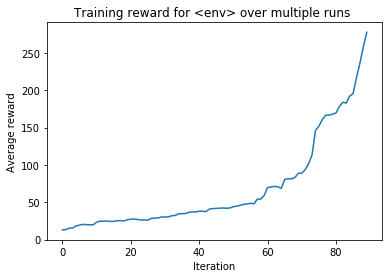

In [59]:
plt.plot(avg_rewards)
plt.title('Training reward for <env> over multiple runs ')
plt.xlabel('Iteration')
plt.ylabel('Average reward')

# BONUS (15% extra)

Compare average returns for CartPole (discrete action space) when using REINFORCE and DQN. Since in REINFORCE we update the network after a set number of steps instead of after every episode, plot the average rewards as a function of steps rather than episodes for both DQN and REINFORCE. You will need to make minor edits to your DQN code from the previous assignment to record average returns as a function of time_steps.

Similarly, compare REINFORCE with DDPG on InvertedPendulum and HalfCheetah using steps for the x-axis.

You may use the example code provided below as a reference for the graphs.


In [64]:
class DQNReplay(object):
# Replay should also have an initialize method which creates a minimum buffer for 
# the initial episodes to generate minibatches.
    def __init__(self, max_size):
        self.buffer = []
        self.capacity = max_size
        self.position = 0
        
    def add_exp(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (np.asarray(state), action, reward, np.asarray(next_state), done)
        self.position = (self.position+1)%self.capacity
    
    def initialize(self, init_length, envir):
        state = envir.reset()
        while True:
            action = envir.action_space.sample()
            next_state, reward, done, _ = envir.step(action)
            self.add_exp(state, action, reward, next_state, done)
            if done:
                state = envir.reset()
                if len(self.buffer)>=init_length:
                    break
            else:
                state = next_state
    
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)
            
    def generate_minibatch(self, DQN, targetDQN, batch_size, gamma):
        states = []
        target_qvalues = []
        actions = np.ones((batch_size,2))
        samples = self.sample(batch_size)
        counter = 0
        for state, action, reward, next_state, done in samples:
            # if done then qvalue is the reward itself
            # else it is reward+gamma*max(targetQ(s'))
            max_qsa = reward
            if not done:
                target_q = to_numpy(targetDQN(to_tensor(next_state)))
                max_qsa += gamma*max(target_q)
            
            # qvalues for the action taken need to be optimized
            y = to_numpy(DQN(to_tensor(state)))
            y[action] = max_qsa
            actions[counter,action] = 1
            counter+=1
            states.append(state)
            target_qvalues.append(y)
            
            
        states = np.asarray(states)
        target_qvalues = np.asarray(target_qvalues)
        return states, actions, target_qvalues
                

In [65]:
 # import your DQN and format your average returns as defined above
class QNetwork(nn.Module):
# Define your network here       
    def __init__(self, learning_rate, state_size, action_size, hidden_size, alpha_decay):
        super(QNetwork, self).__init__()
        self.layer1 = nn.Linear(state_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, action_size)
        
        # Adam optimizer
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        
        # LR Scheduler
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=500, gamma=alpha_decay)
        
        # Mean squared error loss
        self.criterion = nn.MSELoss()
        
    def forward(self, x):
        x = F.tanh(self.layer1(x))
        x = F.tanh(self.layer2(x))
        x = self.layer3(x)
        return x
    
    def run_optimize(self, inputs, targets, mask):
        self.optimizer.zero_grad()
        outputs = self(inputs)
        self.loss = self.criterion(outputs, targets)
        self.loss.backward()
        self.optimizer.step()
        self.scheduler.step()
    
    def copyWeights(self, other):
        self.load_state_dict(other.state_dict())

In [66]:
# Initialize DQN
# Play around with your learning rate, alpha decay and hidden layer units 
# Two layers with a small number of units should be enough

env_name = 'CartPole-v0'
# wrap gym to save videos
env = gym.make(env_name).env
env.reset()
logging_interval = 50
animate_interval = logging_interval * 5
MAX_PATH_LENGTH = 1000

logdir='./DQN/'+env_name

if VISUALIZE:
    if not os.path.exists(logdir):
        os.mkdir(logdir)
    env = gym.wrappers.Monitor(env, logdir, force=True, video_callable=lambda episode_id: episode_id%logging_interval==0)
env._max_episode_steps = MAX_PATH_LENGTH

learning_rate = 0.0008
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
hidden_size = 100
alpha_decay = 0.08
DQN = QNetwork(learning_rate, state_size, action_size, hidden_size, alpha_decay)
targetDQN = QNetwork(learning_rate, state_size, action_size, hidden_size, alpha_decay)
DQN.cuda()
targetDQN.cuda()

# set targetDQN weights to DQN weights
# for ex. targetDQN.model.weights = DQN.model.weights (syntax given here is for representation purpose only)
targetDQN.copyWeights(DQN)

## Initialize Replay Buffer
###################################
## Populate the initial experience buffer
###################################

replay = DQNReplay(max_size=10000)
replay.initialize(init_length=1000, envir=env)

[2018-05-23 21:15:53,039] Making new env: CartPole-v0
[2018-05-23 21:15:53,046] Clearing 31 monitor files from previous run (because force=True was provided)
[2018-05-23 21:15:53,089] Starting new video recorder writing to /datasets/home/09/409/ee276cae/Reinforcement-Learning/hw3 - Policy Gradients/DQN/CartPole-v0/openaigym.video.7.146.video000000.mp4
[2018-05-23 21:15:53,586] Starting new video recorder writing to /datasets/home/09/409/ee276cae/Reinforcement-Learning/hw3 - Policy Gradients/DQN/CartPole-v0/openaigym.video.7.146.video000050.mp4


In [67]:
# Runtime parameters
num_episodes = 2000            # max number of episodes to learn from
gamma = 0.99                   # future reward discount
max_steps = 1000                # cut off simulation after this many steps
batch_size = 250
C = 50

# Exploration parameters
min_epsilon = 0.001             # minimum exploration probability
decay_rate = 5.0/num_episodes    # exponential decay rate for exploration prob
returns = np.zeros(num_episodes)

total_steps = 0
avg_reward = 0.0
avg_rewards_dqn = []
step_list_DQN = []

for ep in range(0, num_episodes):
    epsilon = min_epsilon + (1.0 - min_epsilon)*np.exp(-decay_rate*ep)
    state = env.reset()
    total_reward = 0.0
    steps = 0
    for step in range(max_steps):
        # --> start episode
        q_sa = to_numpy(DQN(to_tensor(state)))
        action = np.argmax(q_sa)
        
        # explore/exploit and get action using DQN
        # binary action space
        if np.random.rand()<epsilon:
            action = env.action_space.sample()
            
        # perform action and record new_state, action, reward
        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        steps+=1
        
        # populate Replay experience buffer
        replay.add_exp(state, action, reward, next_state, done)
        
        if done:
            break
        else:
            state = next_state
        # <-- end episode

    returns[ep] = total_reward
    #print(returns[ep])

    # Replay
    states, actions, target_qvalues = replay.generate_minibatch(DQN, targetDQN, batch_size, gamma)
    
    # set targetDQN weights to DQN weights
    if (ep+1)%C==0:
        print(ep+1, returns[ep])
        targetDQN.copyWeights(DQN)
    
    # update DQN (run one epoch of training per episode with generated minibatch of states and qvalues)
    #for i in range(states.shape[0]):
    #    DQN.run_optimize(to_tensor(states[i]), to_tensor(target_qvalues[i]))
    DQN.run_optimize(to_tensor(states), to_tensor(target_qvalues, requires_grad=False), to_tensor(actions))
        #print(paths)

    if ep == 0:
        avg_reward = total_reward
    else:
        avg_reward = avg_reward * 0.95 + 0.05 * total_reward
    
    if avg_reward > 300:
        break
    
    total_steps += steps
    avg_rewards_dqn.append(avg_reward)
    step_list_DQN.append(total_steps)
    #print(itr,total_steps,path['reward'],len(paths))
    if ep % 100 == 0:
        print('Average reward: {}'.format(avg_reward))

Average reward: 17.0


[2018-05-23 21:15:58,178] Starting new video recorder writing to /datasets/home/09/409/ee276cae/Reinforcement-Learning/hw3 - Policy Gradients/DQN/CartPole-v0/openaigym.video.7.146.video000100.mp4


50 17.0


[2018-05-23 21:16:02,713] Starting new video recorder writing to /datasets/home/09/409/ee276cae/Reinforcement-Learning/hw3 - Policy Gradients/DQN/CartPole-v0/openaigym.video.7.146.video000150.mp4


100 42.0
Average reward: 24.76720338213603


[2018-05-23 21:16:07,404] Starting new video recorder writing to /datasets/home/09/409/ee276cae/Reinforcement-Learning/hw3 - Policy Gradients/DQN/CartPole-v0/openaigym.video.7.146.video000200.mp4


150 37.0


[2018-05-23 21:16:12,161] Starting new video recorder writing to /datasets/home/09/409/ee276cae/Reinforcement-Learning/hw3 - Policy Gradients/DQN/CartPole-v0/openaigym.video.7.146.video000250.mp4


200 12.0
Average reward: 33.47939035003671


[2018-05-23 21:16:16,927] Starting new video recorder writing to /datasets/home/09/409/ee276cae/Reinforcement-Learning/hw3 - Policy Gradients/DQN/CartPole-v0/openaigym.video.7.146.video000300.mp4


250 42.0


[2018-05-23 21:16:21,729] Starting new video recorder writing to /datasets/home/09/409/ee276cae/Reinforcement-Learning/hw3 - Policy Gradients/DQN/CartPole-v0/openaigym.video.7.146.video000350.mp4


300 28.0
Average reward: 38.944611250416195


[2018-05-23 21:16:26,757] Starting new video recorder writing to /datasets/home/09/409/ee276cae/Reinforcement-Learning/hw3 - Policy Gradients/DQN/CartPole-v0/openaigym.video.7.146.video000400.mp4


350 36.0


[2018-05-23 21:16:31,910] Starting new video recorder writing to /datasets/home/09/409/ee276cae/Reinforcement-Learning/hw3 - Policy Gradients/DQN/CartPole-v0/openaigym.video.7.146.video000450.mp4


400 74.0
Average reward: 63.75348484180259


[2018-05-23 21:16:38,193] Starting new video recorder writing to /datasets/home/09/409/ee276cae/Reinforcement-Learning/hw3 - Policy Gradients/DQN/CartPole-v0/openaigym.video.7.146.video000500.mp4


450 128.0


[2018-05-23 21:16:45,718] Starting new video recorder writing to /datasets/home/09/409/ee276cae/Reinforcement-Learning/hw3 - Policy Gradients/DQN/CartPole-v0/openaigym.video.7.146.video000550.mp4


500 335.0
Average reward: 248.5546027458967


Text(0,0.5,'Average reward')

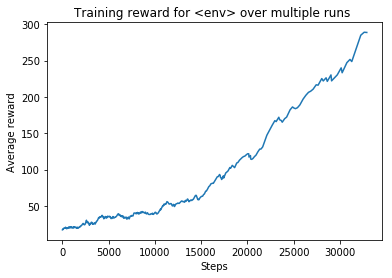

In [69]:
plt.plot(step_list_DQN,avg_rewards_dqn)
plt.title('Training reward for <env> over multiple runs ')
plt.xlabel('Steps')
plt.ylabel('Average reward')

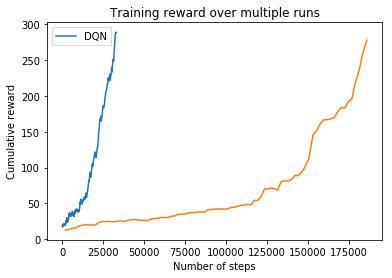

In [71]:
plt.figure()

#out = numpy_ewma_vectorized_v2(np.array(running_rewards_ddpg),20)
plt.plot(step_list_DQN, avg_rewards_dqn) # or plt.plot(step_list_ddpg, out)
plt.title('Training reward over multiple runs')
plt.xlabel('Number of steps')
plt.ylabel('Cumulative reward')
plt.legend(['DQN', 'REINFORCE']) #orplt.legend(['DDPG', 'REINFORCE'])
plt.plot(step_list_reinforce, avg_rewards)

plt.show()